
## Mean flow in three areas (SWOT CalVal)

In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr
#import dask.dataframe as dd

import geopandas as gpd

%matplotlib inline
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
import mitequinox.parcels as pa

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5232775.datarmor0/parcels-502090/libparcels_random_d48d7861-42a3-4b4c-9df1-4f6dccac7bff.so


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=3)

client = Client(cluster)

### Lagrangian data

In [3]:
# Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time_mean'])
df = p.df['time_mean']

df = pa.degs2ms(df) #Convert in m/s 



In [5]:
ds_Lstats = p.load_diagnostic('L_dl1.0_stats.zarr')
ds_Lspectra = p.load_diagnostic('spectra_raw_uv_mean0')
ds_Lstats = ds_Lstats.compute()

In [7]:
ds_Lspectra = ds_Lspectra.persist()

### Eulerian data

In [104]:
def read_Ediag(V,diags):
    ds = xr.merge([ut.load_diagnostic(d+"_"+v).rename({v:d+"_"+v}) 
               for v in V for d in diags])

    grid = xr.open_zarr('/home1/datawork/xyu/grid/mit_grid.zarr')
    ds = xr.merge([ds,grid])
    #ds = ds#.isel(i = slice(0,None,4), j = slice(0,None,4), i_g = slice(0,None,4), j_g = slice(0,None,4))
    ds['lon'] = 0*ds.face+ds.XC
    ds['lat'] = 0*ds.face+ds.YC
    ds = ds.compute()
    # Rotation velocity field
    for diag in diags:
        ds['zonal_velocity_'+diag] =  ds[diag+'_SSU'].rename({'i_g': 'i'})*ds.CS - ds[diag+'_SSV'].rename({'j_g': 'j'})*ds.SN
        ds['meridional_velocity_'+diag] =  ds[diag+'_SSU'].rename({'i_g': 'i'})*ds.SN + ds[diag+'_SSV'].rename({'j_g': 'j'})*ds.CS

        ds['lon'] = 0*ds.face+ds.XC
        ds['lat'] = 0*ds.face+ds.YC
 #   ds = llcreader.faces_dataset_to_latlon(ds)
    return ds

In [105]:
# Eulerian data
V = ["SSU","SSV"]#["SSU", "SSV"]
D = ["mean",'mean_square',"prime_mean_sq"]#, "prime_mean","prime_mean_sq"]
ds = read_Ediag(V,D)

### SWOT CalVal tracks

In [8]:
tracks = ut.load_swot_tracks()

In [9]:
from shapely.geometry import Polygon


In [10]:
def plot_site(bbox, V,vmax,colmap='RdBu_r',figsize=(10,10)):

    central_lon = (bbox[0]+bbox[1])*0.5
    central_lat = (bbox[2]+bbox[3])*0.5

    polygon = Polygon([(bbox[0], bbox[2]), 
                       (bbox[1], bbox[2]), 
                       (bbox[1], bbox[3]), 
                       (bbox[0], bbox[3]), 
                       (bbox[0], bbox[2]),
                      ])
    #poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=world.crs)
    gdf = tracks["swath"]
    gdf_clipped = gpd.clip(gdf, polygon)

    #crs = ccrs.Orthographic(central_lon, central_lat)
    crs = ccrs.AlbersEqualArea(central_lon, central_lat)

    crs_proj4 = crs.proj4_init

    fig, ax = plt.subplots(1, 1, 
                           subplot_kw={'projection': crs},
                           figsize=figsize,
                          )
    #ds_Lstats[V].plot(ax=ax,transform=ccrs.PlateCarree(),y='lat',vmax=vmax,cmap=colmap)
#    ax.set_extent(bbox)

    #_gdf = gdf.cx[bbox[0]:bbox[1], bbox[2]:bbox[3]]
    _gdf = gdf_clipped
    gdf_crs = _gdf.to_crs(crs_proj4)
    ax.add_geometries(gdf_crs['geometry'],
                      crs=crs,
                      facecolor='grey', 
                      edgecolor='black',
                      alpha=0.5,
                     )

    ax.gridlines(draw_labels=True)
#    ax.coastlines(resolution='50m')
    ax.set_extent(bbox)
    return fig, ax

### California

In [84]:
ds_Lstats

<xarray.Dataset>
Dimensions:                            (lat: 179, lon: 359)
Coordinates:
  * lat                                (lat) float64 -89.5 -88.5 ... 87.5 88.5
  * lon                                (lon) float64 -179.5 -178.5 ... 178.5
Data variables: (12/30)
    EKE                                (lon, lat) float64 nan nan ... nan nan
    EKE_binned                         (lon, lat) float64 nan nan ... nan nan
    EKE_ibinned                        (lon, lat) float64 nan nan ... nan nan
    KE                                 (lon, lat) float64 nan nan ... nan nan
    mean_KE                            (lon, lat) float64 nan nan ... nan nan
    mean_KE_binned                     (lon, lat) float64 nan nan ... nan nan
    ...                                 ...
    zonal_velocity_binned_iprime       (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_bprime              (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_bprime_square       (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_iprime              (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_iprime_square       (lon, lat) float64 nan nan ... nan nan
    zonal_velocity_square              (lon, lat) float64 nan nan ... nan nan
Attributes:
    dl:        1.0
    run_name:  global_extra_T365j_dt1j_dij50

In [11]:
V = 'mean_KE_ibinned'
vmax=0.03
colmap = 'viridis'

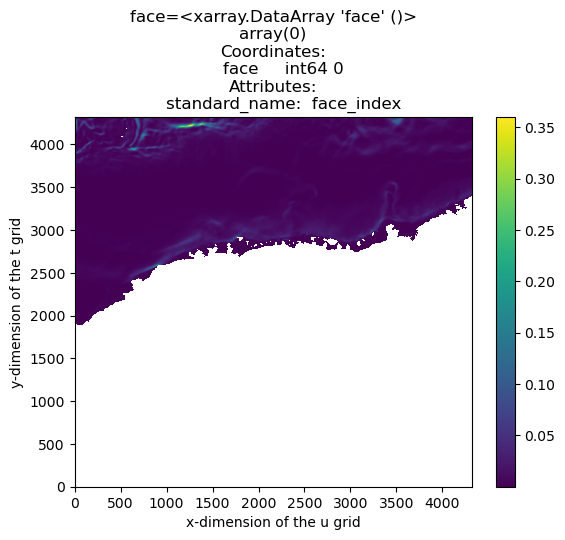

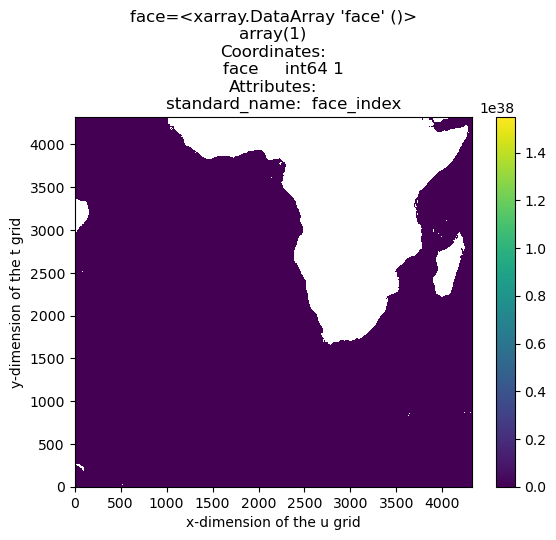

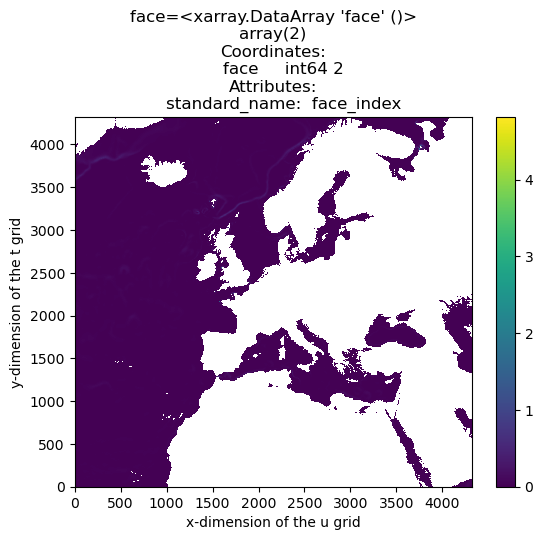

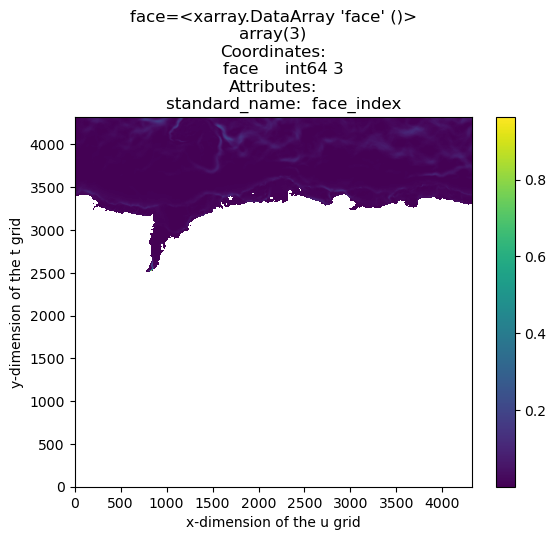

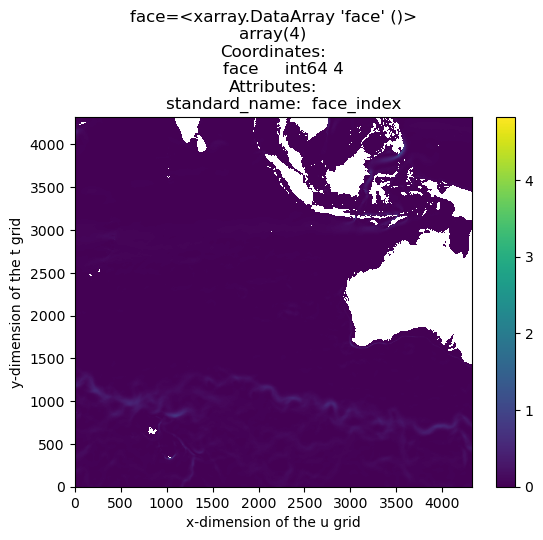

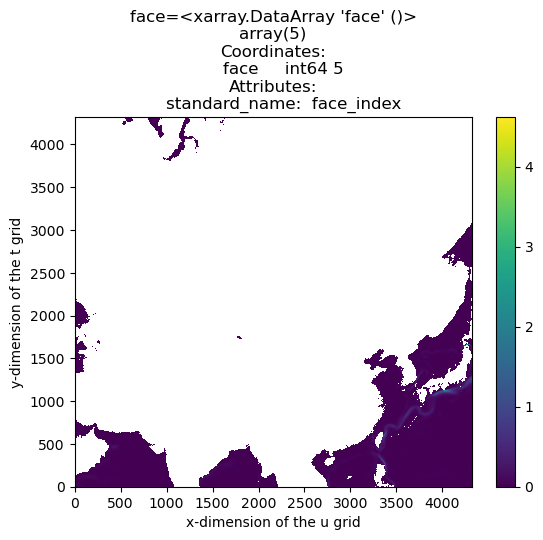

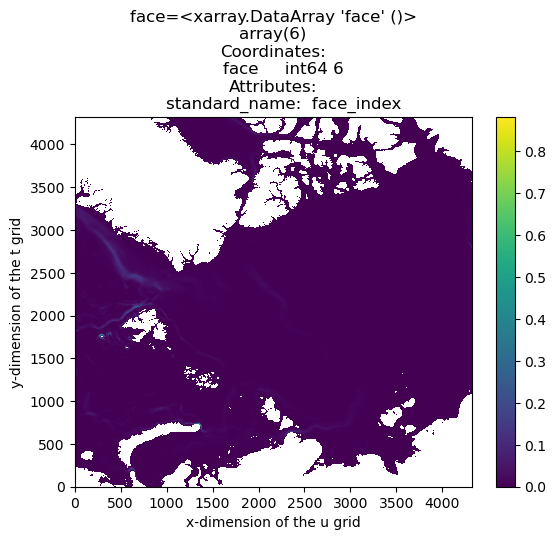

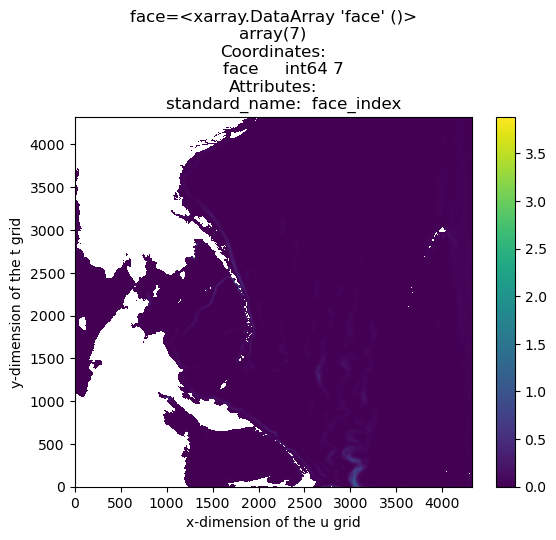

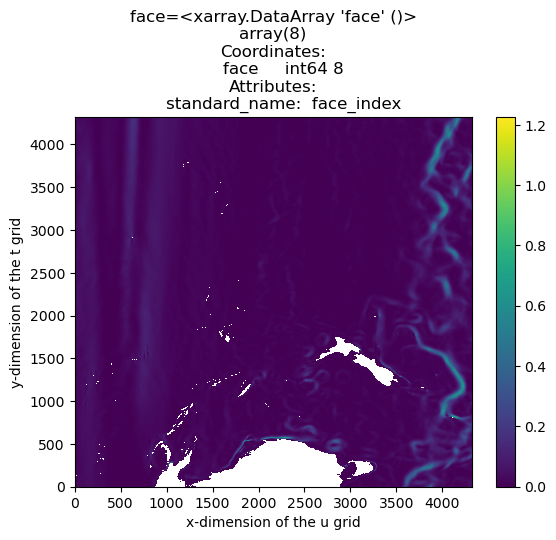

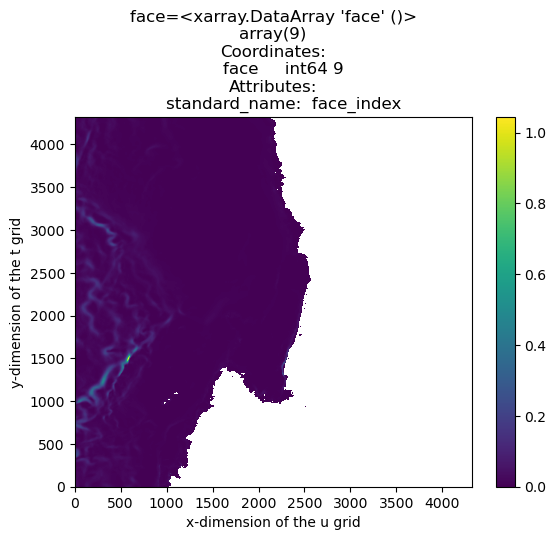

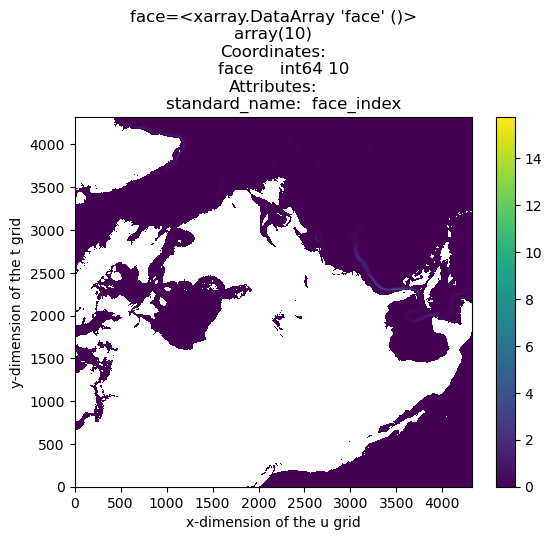

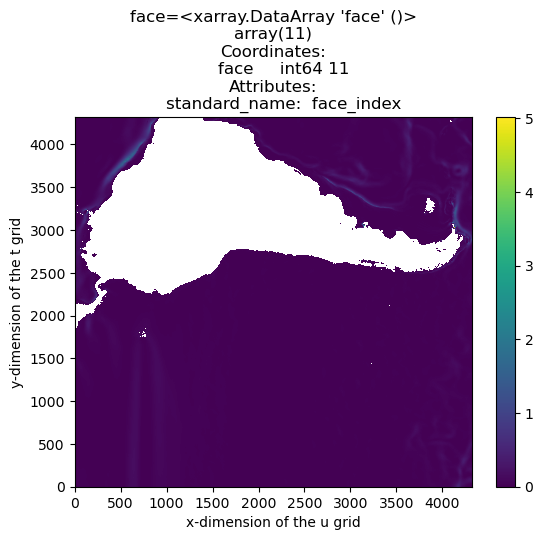

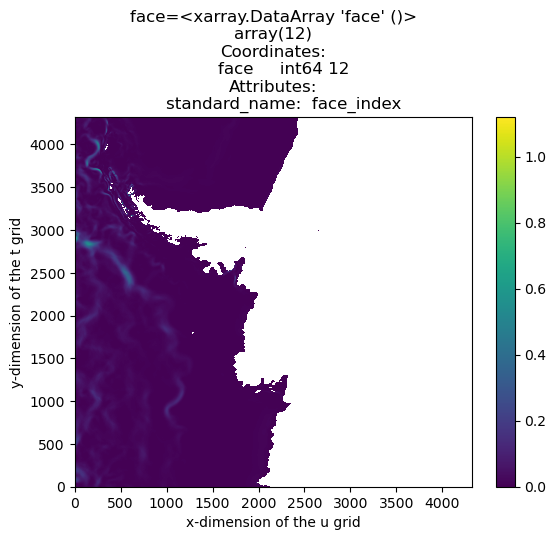

In [118]:
for f in ds.face:
    plt.figure()
    (ds['zonal_velocity_mean']**2+ds['meridional_velocity_mean']**2).sel(face=f).plot()
    plt.title('face=%s'%f)

In [120]:
MKE = (ds.sel(face=10)['zonal_velocity_mean']**2+ds.sel(face=10)['meridional_velocity_mean']**2)

In [130]:
MKE.name = 'MKE'

In [132]:
MKE.name

'MKE'

In [147]:
from xmitgcm import llcreader
V = ["SSU","SSV"]#["SSU", "SSV"]
D = ["mean",'mean_square',"prime_mean_sq"]
ds = xr.merge([ut.load_diagnostic(d+"_"+v).rename({v:d+"_"+v}) 
               for v in V for d in D])

grid = xr.open_zarr('/home1/datawork/xyu/grid/mit_grid.zarr')

ds = xr.merge([ds,grid])


In [148]:
ds_mean = llcreader.faces_dataset_to_latlon(ds)

In [13]:
V = 'mean_KE_ibinned'
vmax=0.03
colmap = 'RdBu_r'

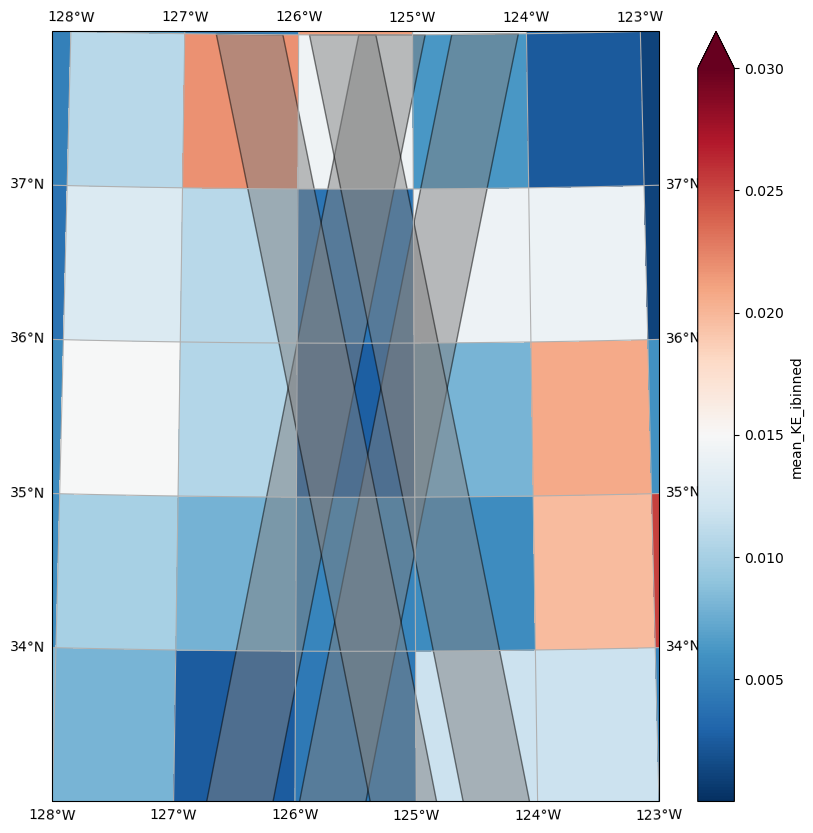

In [14]:
bbox = [-128, -123, 33, 38] # small bbox
fig,ax = plot_site(bbox,V,vmax,colmap=colmap);
ds_Lstats[V].plot(ax=ax,transform=ccrs.PlateCarree(),y='lat',vmax=vmax,cmap=colmap)
#MKE.plot(ax=ax)
#ds_Lstats[V].plot(y='lat',vmax=vmax,cmap=colmap,ax=ax)

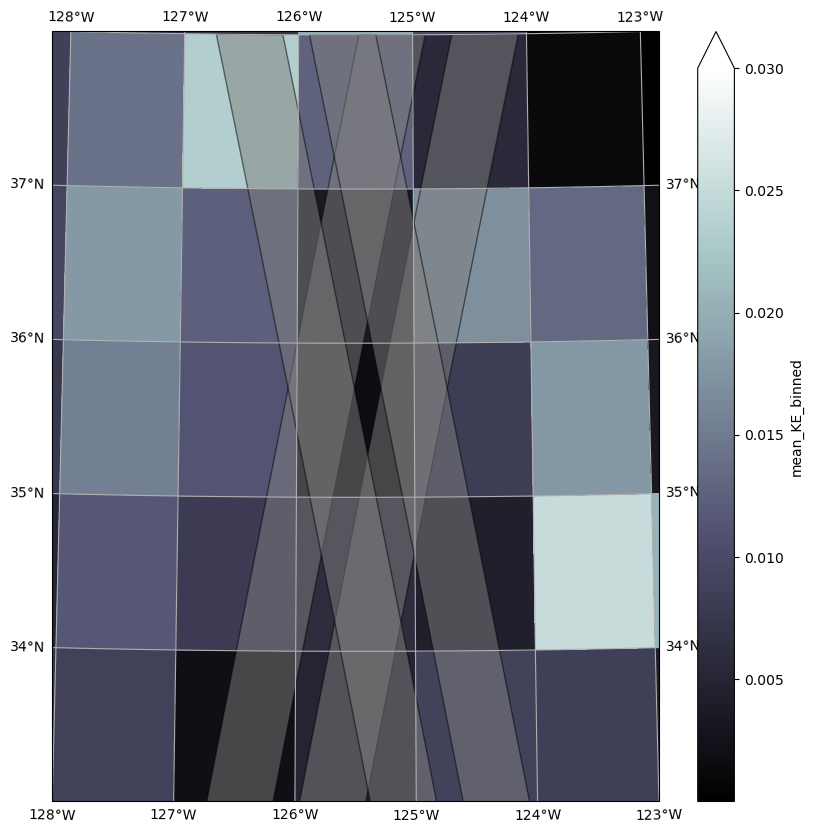

In [103]:
bbox = [-128, -123, 33, 38] # small bbox
fig,ax = plot_site(bbox,'mean_KE_binned',vmax,colmap='bone');

### Mediterranean sea

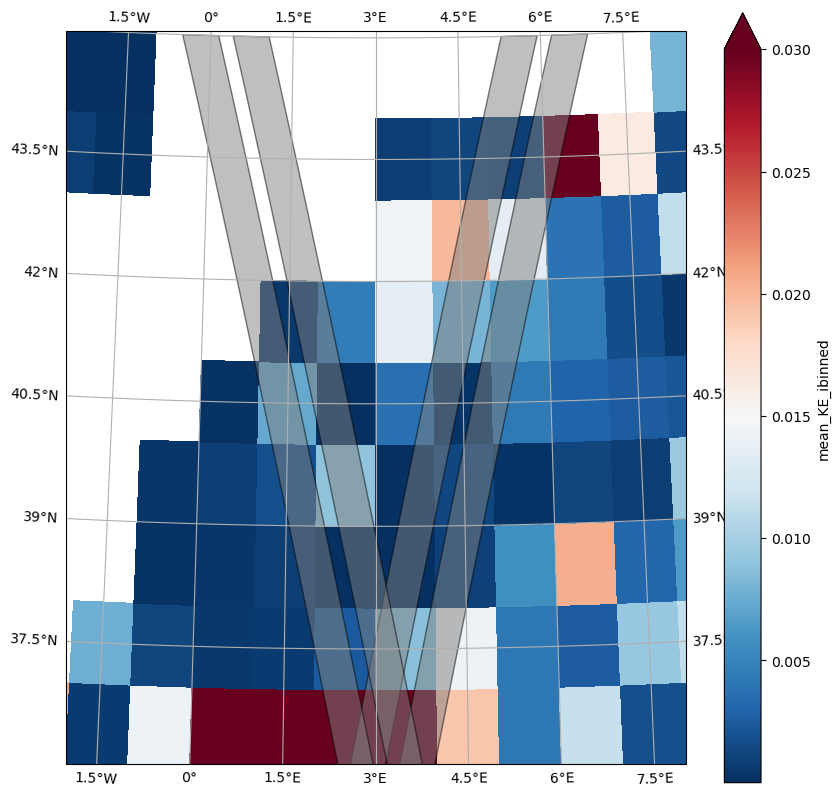

In [15]:
bbox = [-2, 8, 36, 45] # large bbox
fig,ax = plot_site(bbox,V,vmax,colmap=colmap);
ds_Lstats[V].plot(ax=ax,transform=ccrs.PlateCarree(),y='lat',vmax=vmax,cmap=colmap)
#plot_site(bbox,V,vmax,colmap='bone');

### North-West Australia

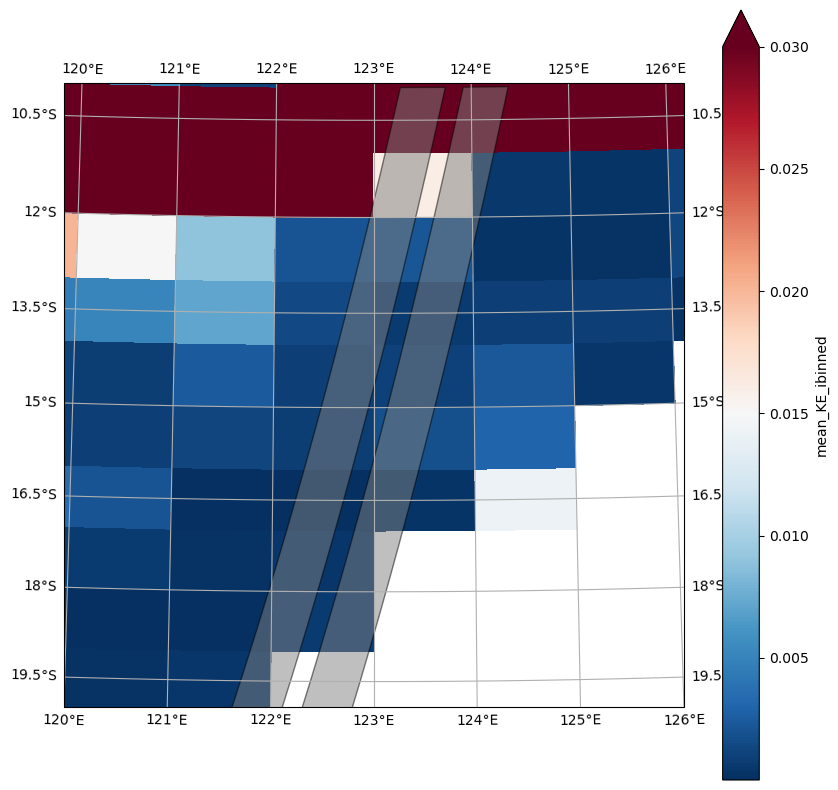

In [16]:
bbox = [120, 126, -20, -10]
fig,ax = plot_site(bbox,V,vmax,colmap=colmap);
ds_Lstats[V].plot(ax=ax,transform=ccrs.PlateCarree(),y='lat',vmax=vmax,cmap=colmap)
#plot_site(bbox,V,0.009,colmap='bone');

In [29]:
ds = _ds.rename(columns={'lon_cut': 'lon_bins', 'value': 'uv'}
               ).to_xarray().set_index(index=['lon_bins','frequency']).unstack()

In [30]:
_ds = pd.melt(uv_mean1.set_index(uv_mean1.index.map(lambda v: v.mid)).drop(columns=['time','lon','lat']).reset_index()
         ,id_vars=['lon_cut'],var_name='frequency')

_ds['frequency'] = _ds['frequency'].astype('float64')

In [40]:
ds['uv_mean1'] = _ds.rename(columns={'lon_cut': 'lon_bins', 'value': 'uv_mean1'}
                           ).to_xarray().set_index(index=['lon_bins','frequency']).unstack().uv_mean1

In [41]:
_ds = pd.melt(uv_mean2.set_index(uv_mean2.index.map(lambda v: v.mid)).drop(columns=['time','lon','lat']).reset_index()
         ,id_vars=['lon_cut'],var_name='frequency')

_ds['frequency'] = _ds['frequency'].astype('float64')

In [43]:
ds['uv_mean2'] = _ds.rename(columns={'lon_cut': 'lon_bins', 'value': 'uv_mean2'}
                           ).to_xarray().set_index(index=['lon_bins','frequency']).unstack().uv_mean2

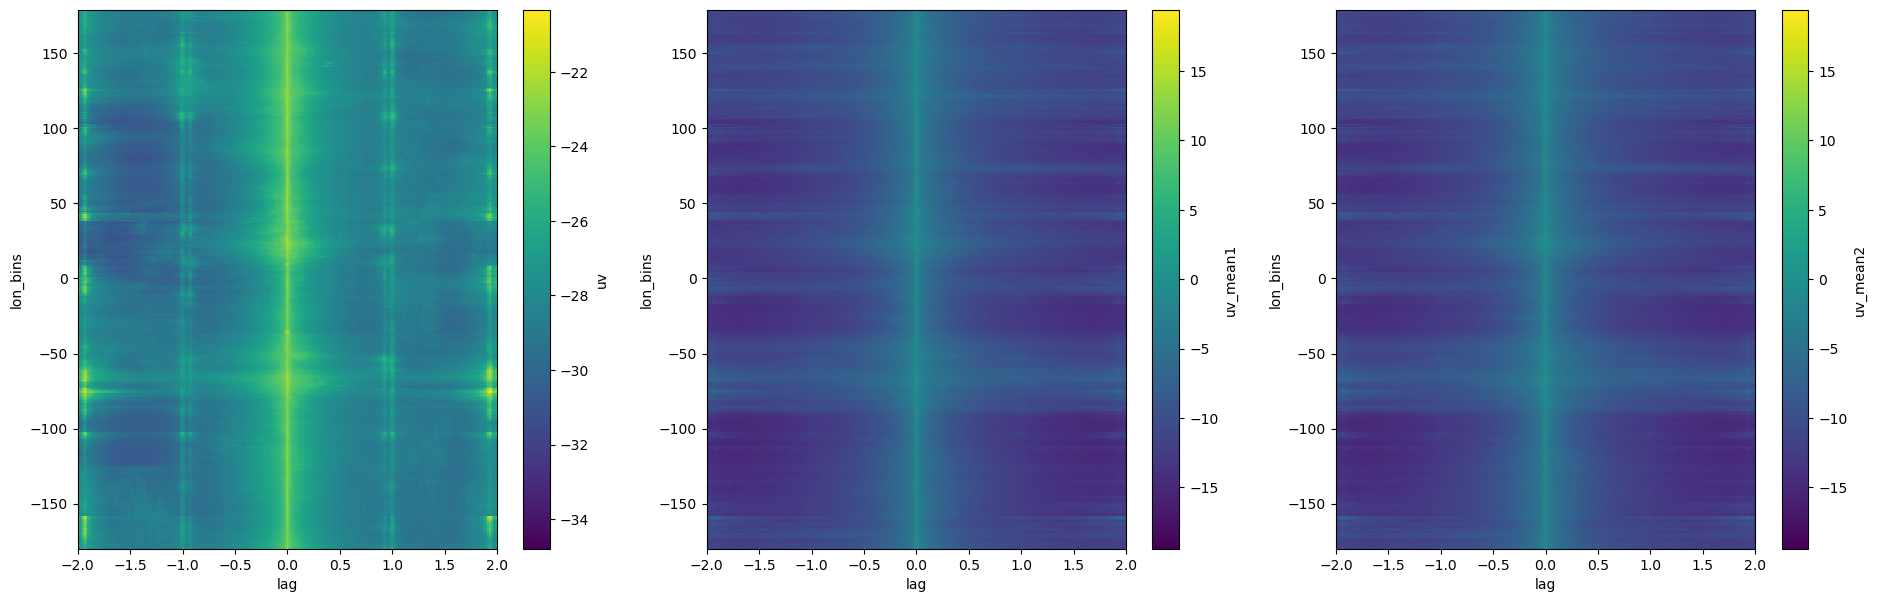

In [56]:
fig,axs = plt.subplots(1,3,figsize=(23,7))
for V,ax in zip(ds.keys(),axs):
    np.log(ds[V]).plot(ax=ax,cmap='viridis')
    ax.set_xlim(-2,2)

In [57]:
bbox = [-128, -123, 33, 38] # small bbox


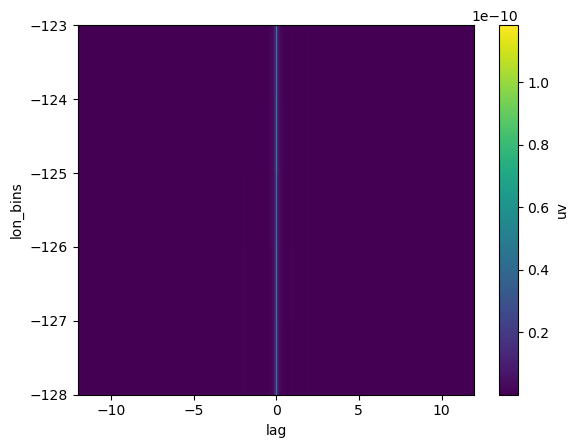

In [58]:
ds.uv.sel(lon_bins=slice(bbox[0],bbox[1])).plot()

In [59]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
